In [1]:
import gym
import numpy as np
from offsim4rl.envs import gridworld
from offsim4rl.agents import spinup
import torch

No protocol specified


In [2]:
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.per_state_rejection import PerStateRejectionSampling
from offsim4rl.evaluators.queue_evaluator import QueueEvaluator

In [3]:
# the oracle observation-to-state mapping for the continuous gridworld
class OracleEncoder(object):
    def __init__(self):
        pass
    def encode(self, observations):
        zs = []
        for x, y in observations:
            xx, yy = int(x*5), int(y*5)
            z = xx + 5*yy
            zs.append(z)
        return zs

In [4]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
from offsim4rl.data import SAS_Dataset
from offsim4rl.encoders.homer import HOMEREncoder
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.41it/s]


In [5]:
dataset = OfflineDataset(
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)),
    action_space=gym.spaces.Discrete(5),
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-17 21:29:54,722 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [6]:
psrs = PerStateRejectionSampling(
    dataset,
    num_states=25,
    encoder=OracleEncoder(),
)

In [7]:
qbe = QueueEvaluator(
    dataset,
    num_states=25,
    encoder=OracleEncoder(),
)

In [8]:
from offsim4rl.agents import tabular
from offsim4rl.envs import gridworld

In [9]:
env_ = gridworld.MyGridNavi(num_steps=1000)
env_.reset_task(np.array([4,4]))

array([4, 4])

In [10]:
Q_star, _ = tabular.qlearn(env_, 100, tabular.epsilon_greedy_policy, gamma=1, alpha=1, epsilon=1, seed=0, save_Q=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.68it/s]


In [11]:
pi_ = tabular.epsilon_greedy_policy(Q_star, dict(epsilon=0.4))

In [12]:
def policy_(coords):
    x, y = coords
    col, row = int(np.floor(x*5)), int(np.floor(y*5))
    idx = col + row * 5
    return pi_[idx]

## Visualize trajectories

### PSRS

In [13]:
psrs.reset_sampler(seed=0)

In [14]:
gamma = 1.0
episodes_psrs = []
for i in range(50):
    G = 0
    t = 0
    S = psrs.reset(seed=i)
    rng = np.random.default_rng(seed=i)
    done = False
    episode = []
    while not done: # S is not a terminal state
        p = torch.distributions.Categorical(probs=torch.tensor(policy_(tuple(S))))
        A, S_, R, done, info = psrs.step_dist(p)
        episode.append((S, A, R, S_, done, p, {**info, 't': t}))

        S = S_
        G = G + (gamma ** t) * R
        t = t + 1
    episodes_psrs.append(episode)

In [15]:
import gym
import numpy as np
import matplotlib.pyplot as plt

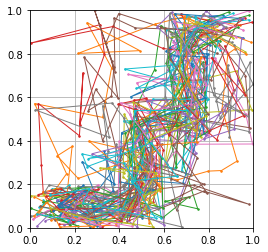

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
for episode in episodes_psrs:
    plt.plot([xy[0] for xy, *_ in episode] + [episode[-1][3][0]], [xy[1] for xy, *_ in episode] + [episode[-1][3][1]], marker='.', lw=1, ms=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.show()

### Queue-based evaluator

In [17]:
qbe.reset_sampler(seed=0)

In [18]:
gamma = 1.0
episodes_qbe = []
for i in range(50):
    ep_psrs = episodes_psrs[i]
    G = 0
    t = 0
    S = qbe.reset(seed=i)
    rng = np.random.default_rng(seed=i)
    done = False
    episode = []
    while not done:
        if t == len(ep_psrs):
            break
        A = ep_psrs[t][1]
        S_, R, done, info = qbe.step(A)
        episode.append((S, A, R, S_, done, p, {**info, 't': t}))

        S = S_
        G = G + (gamma ** t) * R
        t = t + 1
    episodes_qbe.append(episode)

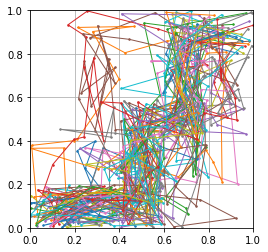

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
for episode in episodes_qbe:
    plt.plot([xy[0] for xy, *_ in episode] + [episode[-1][3][0]], [xy[1] for xy, *_ in episode] + [episode[-1][3][1]], marker='.', lw=1, ms=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.show()

### Real MDP

In [20]:
env = gym.make('MyGridNaviCoords-v1')
env.reset_task(np.array([4,4]))

array([4, 4])

In [21]:
gamma = 1.0
episodes = []
for i in range(50):
    ep_psrs = episodes_psrs[i]
    G = 0
    t = 0
    S = env.reset(seed=i)
    rng = np.random.default_rng(seed=i)
    done = False
    episode = []
    while not done:
        if t == len(ep_psrs):
            break
        A = ep_psrs[t][1]
        S_, R, done, info = env.step(A)
        episode.append((S, A, R, S_, done, p, {**info, 't': t}))

        S = S_
        G = G + (gamma ** t) * R
        t = t + 1
    episodes.append(episode)

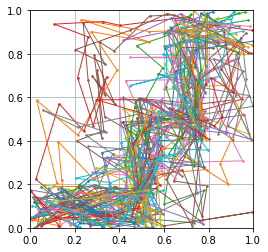

In [22]:
fig, ax = plt.subplots(figsize=(4,4))
for episode in episodes:
    plt.plot([xy[0] for xy, *_ in episode] + [episode[-1][3][0]], [xy[1] for xy, *_ in episode] + [episode[-1][3][1]], marker='.', lw=1, ms=3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Combined & Compare

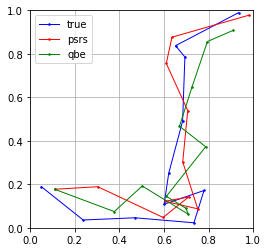

In [23]:
fig, ax = plt.subplots(figsize=(4,4))
k = 12
for ep1, ep2, ep3 in zip(episodes[k:k+1], episodes_psrs[k:k+1], episodes_qbe[k:k+1]):
    plt.plot([xy[0] for xy, *_ in ep1] + [ep1[-1][3][0]], [xy[1] for xy, *_ in ep1] + [ep1[-1][3][1]], marker='.', lw=1, ms=3, c='b', label='true')
    plt.plot([xy[0] for xy, *_ in ep2] + [ep2[-1][3][0]], [xy[1] for xy, *_ in ep2] + [ep2[-1][3][1]], marker='.', lw=1, ms=3, c='r', label='psrs')
    plt.plot([xy[0] for xy, *_ in ep3] + [ep3[-1][3][0]], [xy[1] for xy, *_ in ep3] + [ep3[-1][3][1]], marker='.', lw=1, ms=3, c='g', label='qbe')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()

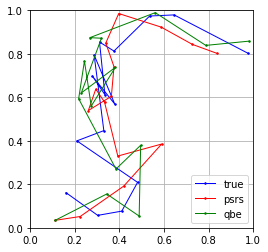

In [33]:
fig, ax = plt.subplots(figsize=(4,4))
k = 5
for ep1, ep2, ep3 in zip(episodes[k:k+1], episodes_psrs[k:k+1], episodes_qbe[k:k+1]):
    plt.plot([xy[0] for xy, *_ in ep1] + [ep1[-1][3][0]], [xy[1] for xy, *_ in ep1] + [ep1[-1][3][1]], marker='.', lw=1, ms=3, c='b', label='true')
    plt.plot([xy[0] for xy, *_ in ep2] + [ep2[-1][3][0]], [xy[1] for xy, *_ in ep2] + [ep2[-1][3][1]], marker='.', lw=1, ms=3, c='r', label='psrs')
    plt.plot([xy[0] for xy, *_ in ep3] + [ep3[-1][3][0]], [xy[1] for xy, *_ in ep3] + [ep3[-1][3][1]], marker='.', lw=1, ms=3, c='g', label='qbe')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()